
=== Processing: C:/Users/wsfm/OneDrive - Loughborough University/_Personal_Backup/ground_based_solar_irradiance/assets\calibration_outdoor_filtering\channel_7_class_C.csv
Saved: C:/Users/wsfm/OneDrive - Loughborough University/_Personal_Backup/ground_based_solar_irradiance/v_results_3_output\Figure_3_3_3_RSD__channel_7_class_C.png  &  C:/Users/wsfm/OneDrive - Loughborough University/_Personal_Backup/ground_based_solar_irradiance/v_results_3_output\Figure_3_3_3_RSD__channel_7_class_C.svg
Saved: C:/Users/wsfm/OneDrive - Loughborough University/_Personal_Backup/ground_based_solar_irradiance/v_results_3_output\Figure_3_3_3_expRSD__channel_7_class_C.png  &  C:/Users/wsfm/OneDrive - Loughborough University/_Personal_Backup/ground_based_solar_irradiance/v_results_3_output\Figure_3_3_3_expRSD__channel_7_class_C.svg

=== Processing: C:/Users/wsfm/OneDrive - Loughborough University/_Personal_Backup/ground_based_solar_irradiance/assets\calibration_outdoor_filtering\channel_4_class_A_pyr_24.csv
S

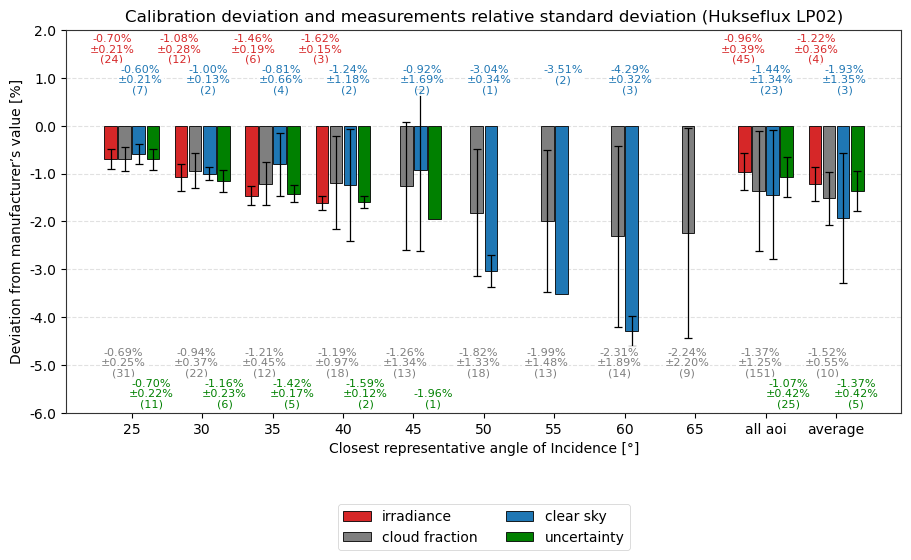

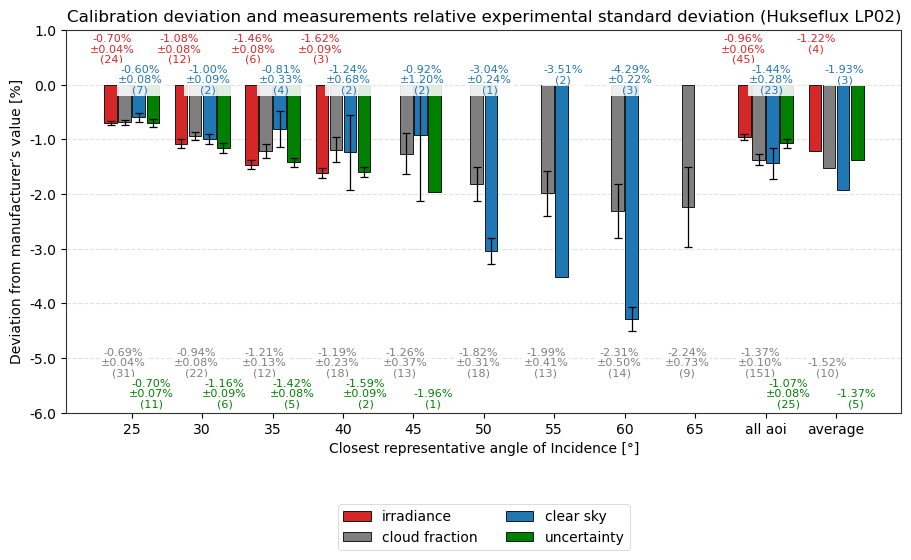

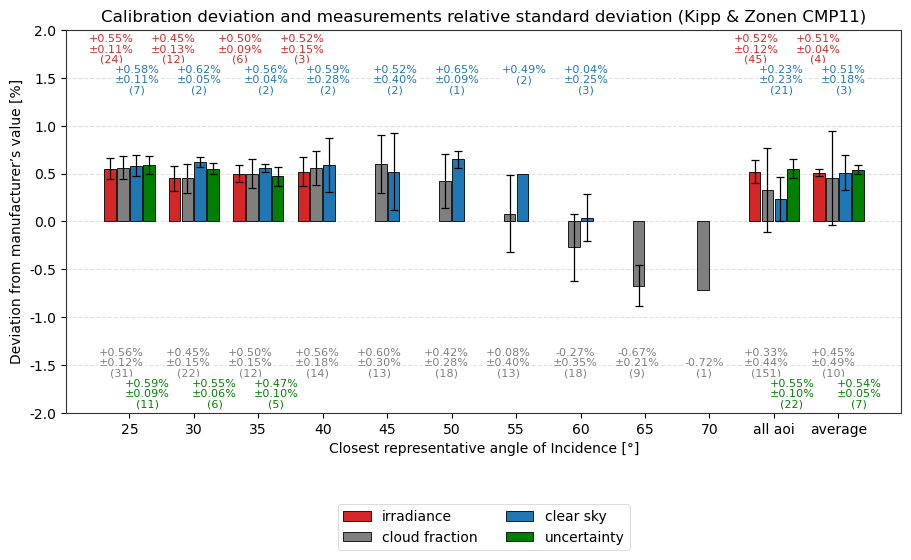

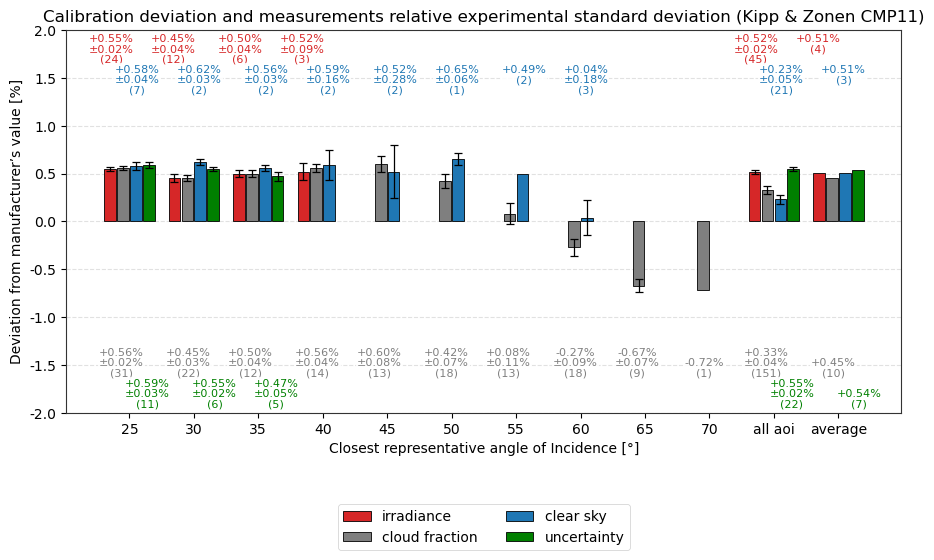

In [54]:
import os
BASE_DIR= r"C:/Users/wsfm/OneDrive - Loughborough University/_Personal_Backup/ground_based_solar_irradiance/"
OUT_DIR = os.path.join(BASE_DIR,"v_results_3_output")
INP_DIR = os.path.join(BASE_DIR,"assets","calibration_outdoor_filtering")
CSVS = ["channel_7_class_C.csv","channel_4_class_A_pyr_24.csv"]

# -*- coding: utf-8 -*-
"""
Figures 3.3.3 (style) — Deviation bars with SD error bars (two variants per CSV)

Per CSV, we produce:
  1) Deviation with Relative standard deviation (RSD) as error bar
  2) Deviation with Relative experimental standard deviation (ExpRSD) as error bar

CSV format expected (as in your harmonised files):
filter,parameter,25,30,35,40,45,50,55,60,65,70,All
irradiance,deviation from manufacturer's value,-0.70%,-1.08%,...,-0.96%
irradiance,relative standard deviation,0.21%,0.28%,...,0.39%
irradiance,relative experimental standard deviation,0.04%,0.08%,...,0.06%
cloud fraction, ...
clear sky, ...
uncertainty, ...

Label layout (per IP-6):
  • Alternate top/bottom (parity of AOI index + filter index),
  • All TOP labels aligned on one common horizontal line (inside the axes),
  • All BOTTOM labels aligned on one common horizontal line (inside the axes),
  • Label color = series color; for 'irradiance' you can toggle yellow vs black for readability.
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

# ----------------------- Configure your paths/files -----------------------
BASE_DIR = r"C:/Users/wsfm/OneDrive - Loughborough University/_Personal_Backup/ground_based_solar_irradiance/"
INP_DIR  = os.path.join(BASE_DIR, "assets", "calibration_outdoor_filtering")
OUT_DIR  = os.path.join(BASE_DIR, "v_results_3_output")

# Process BOTH files (order doesn’t matter)
CSVS = [
    "channel_7_class_C.csv",
    "channel_4_class_A_pyr_24.csv",
]

CSVS_PYRANOMETERS = {"channel_7_class_C.csv": "Hukseflux LP02",
               "channel_4_class_A_pyr_24.csv": "Kipp & Zonen CMP11"
}


os.makedirs(OUT_DIR, exist_ok=True)

# ----------------------- Domain settings -----------------------
AOI_ORDER = ["25","30","35","40","45","50","55","60","65","70","all aoi","average"]

# Two figure variants requested (error source, figure code suffix, y-axis label)
ERROR_SPECS = [
    ("relative standard deviation",              "RSD",    "Deviation from manufacturer’s value [%]"),
    ("relative experimental standard deviation", "expRSD", "Deviation from manufacturer’s value [%]"),
]

# Color mapping (consistent with Fig. 3.3.2)
COLORS = {
    "irradiance":     "#d62728",  # "#FFA500 # orabge # yellow "#f1c40f", 
    # "normal incidence":     "#d62728",  # "#FFA500 # orabge # yellow "#f1c40f", 
    "cloud fraction": "#7f7f7f",  # grey
    "clear sky":      "#1f77b4",  # blue
    "uncertainty":    "#008000",  # green #f1c40f # red #d62728
}
FILTER_ORDER = ["irradiance", "cloud fraction", "clear sky", "uncertainty"]
# FILTER_ORDER = ["normal incidence", "cloud fraction", "clear sky", "uncertainty"]

# ----------------------- Label layout (top/bottom aligned) -----------------------
LABEL_FS        = 8   # restored size
TOP_MARGIN_FRAC = 0.024 # how far below the top edge to place TOP labels (fraction of y-span)
BOT_MARGIN_FRAC = 0.024 # how far above the bottom edge to place BOTTOM labels
TOP_MARGIN_FRAC = 0.070 # how far below the top edge to place TOP labels (fraction of y-span)
BOT_MARGIN_FRAC = 0.070 # how far above the bottom edge to place BOTTOM labels
H_JITTER        = 0.020 # small horizontal jitter (x-data units) to reduce side-by-side collisions
ALT_PLACE       = True  # alternate top/bottom by (AOI idx + filter idx) parity
USE_YELLOW_LABELS = True  # if False, 'irradiance' labels are black for legibility instead of yellow

# Slight vertical staggering at the edges to separate labels at the same edge (optional)
EDGE_STAGGER_FRAC = 0.008  # small extra vertical offset per filter index at an edge
EDGE_STAGGER_FRAC = 0.040  # small extra vertical offset per filter index at an edge

# ----------------------- Utilities -----------------------
def _clean_percent(x: str) -> float:
    """Convert percent-like string to float (in %-points); placeholders → NaN."""
    if x is None:
        return np.nan
    s = str(x).strip()
    if s == "" or s.upper() in {"#N/A", "#REF!", "#DIV/0!"}:
        return np.nan
    s = (s.replace("\u00A0", "")
           .replace("\u2009", "")
           .replace(" ", "")
           .replace(",", ".")
           .replace("%", ""))
    try:
        return float(s)
    except ValueError:
        return np.nan

def load_tidy_from_csv(path: str) -> pd.DataFrame:
    """
    Read one CSV and return tidy table: ['filter','parameter','aoi','value']
    Values are floats in %, NaN for placeholders.
    """
    df = pd.read_csv(path, dtype=str)
    required = {"filter","parameter"} | set(AOI_ORDER)
    missing  = [c for c in required if c not in df.columns]
    if missing:
        raise KeyError(f"Missing required columns in {os.path.basename(path)}: {missing}")

    rows = []
    for _, row in df.iterrows():
        filt  = str(row["filter"]).strip().lower()
        param = str(row["parameter"]).strip().lower()
        for aoi in AOI_ORDER:
            rows.append((filt, param, aoi, _clean_percent(row[aoi])))
    tidy = pd.DataFrame(rows, columns=["filter","parameter","aoi","value"])
    return tidy

def _nice_ylim_for_deviation_with_error(dev: np.ndarray, err: np.ndarray):
    """
    Compute y-limits so both bars (deviation) and error bars fit with headroom.
    dev, err are 2D arrays (AOI x filter) with NaNs allowed.
    """
    dev_num = np.nan_to_num(dev, nan=np.nan)  # keep NaNs
    err_num = np.nan_to_num(err, nan=0.0)
    if not np.isfinite(dev_num).any():
        return (-1.0, 1.0)
    low  = np.nanmin(dev_num - err_num)
    high = np.nanmax(dev_num + err_num)
    span = max(high - low, 1.0)
    pad  = max(0.15 * span, 0.35)  # ≥ 0.35 %-pt headroom
    return (np.floor(low - pad), np.ceil(high + pad))

# ----------------------- Plotting -----------------------
def plot_deviation_with_errorbars(
    tidy: pd.DataFrame,
    error_param_name: str,
    fig_suffix: str,
    y_label: str,
    out_prefix: str,
    title:str
):
    """
    Grouped bars:
      - Bar height = deviation from manufacturer's value [%]
      - Error bar  = <error_param_name> [%] (RSD or expRSD)
    Legend = filters; x-axis = AOI bins.
    Labels alternate top/bottom but are snapped to two common y-lines.
    """
    # Subset for needed parameters
    dev_df = tidy[tidy["parameter"] == "deviation from manufacturer's value"].copy()
    err_df = tidy[tidy["parameter"] == error_param_name].copy()
    count_df = tidy[tidy["parameter"] == "number of calibration factors"].copy()

    # Keep only filters we have colors for
    keep_filters = set(COLORS.keys())
    dev_df = dev_df[dev_df["filter"].isin(keep_filters)]
    err_df = err_df[err_df["filter"].isin(keep_filters)]
    count_df = count_df[count_df["filter"].isin(keep_filters)]

    # Ensure AOI order and sort
    dev_df["aoi"] = pd.Categorical(dev_df["aoi"], categories=AOI_ORDER, ordered=True)
    err_df["aoi"] = pd.Categorical(err_df["aoi"], categories=AOI_ORDER, ordered=True)
    count_df["aoi"] = pd.Categorical(count_df["aoi"], categories=AOI_ORDER, ordered=True)

    dev_df.sort_values(["aoi","filter"], inplace=True)
    err_df.sort_values(["aoi","filter"], inplace=True)
    count_df = count_df.drop_duplicates(subset=['aoi', 'filter'])
    count_df.sort_values(['aoi','filter'], inplace=True)      

    # Pivot to matrices AOI x filter
    dev_mat = (dev_df.pivot(index="aoi", columns="filter", values="value")
                       .reindex(index=AOI_ORDER, columns=FILTER_ORDER))
    err_mat = (err_df.pivot(index="aoi", columns="filter", values="value")
                       .reindex(index=AOI_ORDER, columns=FILTER_ORDER))    
    count_mat = count_df.pivot(index="aoi", columns="filter", values="value").reindex(index=AOI_ORDER, columns=FILTER_ORDER)

    # Drop AOIs with all NaNs in deviation (nothing to draw)
    dev_mat = dev_mat.dropna(how="all", axis=0)
    err_mat = err_mat.loc[dev_mat.index]  # align rows
    count_mat = count_mat.loc[dev_mat.index] 

    # Figure
    fig, ax = plt.subplots(figsize=(9.6, 5.8))
    plt.rcParams.update({
        "axes.edgecolor": "#333", "axes.linewidth": 0.8,
        "grid.color": "#bdbdbd", "grid.linestyle": "--", "grid.alpha": 0.45,
        "axes.grid": True, "font.size": 10,
    })

    X = dev_mat.shape[0]
    filters = [f for f in FILTER_ORDER if f in dev_mat.columns]
    F = len(filters)
    x = np.arange(X)
    bar_w = min(0.8 / max(F,1), 0.18)
    pad   = 0.02

    # Compute y-limits with headroom for bars + error bars
    y_min, y_max = _nice_ylim_for_deviation_with_error(
        dev_mat.to_numpy(dtype=float),
        err_mat.to_numpy(dtype=float)
    )

    # Pre-compute two *shared* label baselines inside the axes
    y_span  = max(y_max - y_min, 1e-6)
    y_top   = y_max - TOP_MARGIN_FRAC * y_span     # all TOP labels align here
    y_bottom= y_min + BOT_MARGIN_FRAC * y_span     # all BOTTOM labels align here


    # Draw bars + error bars + labels (labels snapped to top/bottom lines)
    for j, filt in enumerate(filters):
        offs = (j - (F - 1) / 2) * (bar_w + pad)
        y_dev = dev_mat[filt].to_numpy(dtype=float)  # deviation values
        y_err = err_mat[filt].to_numpy(dtype=float)  # error values (%)
        y_count = count_mat[filt].to_numpy(dtype=int)

        # Bars
        ax.bar(
            x + offs, y_dev, width=bar_w,
            color=COLORS[filt], edgecolor="black", linewidth=0.6,
            label=filt, zorder=3
        )

        # Error bars
        ax.errorbar(
            x + offs, y_dev, yerr=y_err, fmt="none",
            ecolor="black", elinewidth=0.9, capsize=3, capthick=0.9, zorder=4
        )

        ax.set_title(title)

        # Choose label color (series color, with option to keep irradiance labels black)
        base_label_color = COLORS[filt]
        if filt == "irradiance" and not USE_YELLOW_LABELS:
        # if filt == "normal incidence" and not USE_YELLOW_LABELS:
            base_label_color = "#111"  # override for legibility on yellow series

        # Labels: "value% ± err%" — placed at the common top/bottom y-lines
        for i in range(X):
            v = y_dev[i]
            cnt = y_count[i]
            e = y_err[i] if np.isfinite(y_err[i]) else np.nan
            if not np.isfinite(v):
                continue

            # Compose label text (1 decimal as in Fig 3.1.1 style, or keep 1–2 as you prefer)
            if np.isfinite(e):
                txt = f"{v:+.2f}%\n±{e:.2f}%\n({cnt})"
            else:
                txt = f"{v:+.2f}%\n({cnt})"

            TEST = True

            # Alternate placement by (AOI idx + filter idx)
            place_top = True
            if ALT_PLACE:
                # place_top = ((i + j) % 2 == 0)
                if filt in ["irradiance","clear sky"]: 
                    place_top = True
                else: place_top = False

            # small horizontal jitter to reduce same-edge crowding
            x_jit = (H_JITTER if ((i + j) % 2 == 0) else -H_JITTER)

            # slight vertical staggering per filter index to improve edge separation
            v_stag = EDGE_STAGGER_FRAC * y_span * (j - (F - 1) / 2)

            if place_top:
                y_text = y_top - v_stag  # subtract so different filters separate slightly
                va = "top"               # anchor from the top edge position
            else:
                y_text = y_bottom - v_stag  # add so different filters separate slightly
                va = "bottom"            # anchor from the bottom edge position
            
            ax.text(
                x[i] + offs + x_jit, 
                y_text, 
                txt,
                ha="center", 
                va=va, 
                fontsize=LABEL_FS, 
                color=base_label_color,
                bbox=dict(facecolor="white", edgecolor="none", alpha=0.88, pad=0.8),
                linespacing=1.05, 
                clip_on=False, 
                zorder=5
            )
            

            if TEST == False:

                # Alternate top/bottom by parity; tiny horizontal jitter to avoid same-x overlap
                place_top = ((i + j) % 2 == 0) if ALT_PLACE else True
                x_jit = (H_JITTER if ((i + j) % 2 == 0) else -H_JITTER)

                ax.text(
                    x[i] + offs + x_jit,
                    (y_top if place_top else y_bottom),
                    txt,
                    ha="center",
                    va=("top" if place_top else "bottom"),
                    fontsize=LABEL_FS,
                    color=base_label_color,
                    bbox=dict(facecolor="white", edgecolor="none", alpha=0.88, pad=0.8),
                    linespacing=1.05,
                    clip_on=False,
                    zorder=5
                )

    # Axes, grid, legend
    ax.set_xticks(x)
    ax.set_xticklabels(dev_mat.index.tolist())
    ax.set_xlabel("Closest representative angle of Incidence [°]")  # or "" if you prefer no x-label
    ax.set_ylabel(y_label)
    ax.set_ylim(y_min, y_max)
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))

    ax.grid(True, axis="y"); ax.grid(False, axis="x")

    leg = ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.22), ncol=2, frameon=True)
    leg.get_frame().set_linewidth(0.6)
    fig.subplots_adjust(bottom=0.30, left=0.11, right=0.98, top=0.96)

    # Save
    png = os.path.join(OUT_DIR, f"Figure_3_3_3_{fig_suffix}__{out_prefix}.png")
    svg = os.path.join(OUT_DIR, f"Figure_3_3_3_{fig_suffix}__{out_prefix}.svg")
    fig.savefig(png, dpi=300)
    fig.savefig(svg)
    print(f"Saved: {png}  &  {svg}")

# ----------------------- Main -----------------------
def main_one_csv(inp_dir:str, fname:str):
    csv_path = os.path.join(inp_dir, fname)
    print(f"\n=== Processing: {csv_path}")
    tidy = load_tidy_from_csv(csv_path)
    stem = os.path.splitext(os.path.basename(csv_path))[0]
    for err_param, suffix, ylab in ERROR_SPECS:
        plot_deviation_with_errorbars(
            tidy=tidy,
            error_param_name=err_param,
            fig_suffix=suffix,
            y_label=ylab,
            out_prefix=stem,
            title = f"Calibration deviation and measurements {err_param} ({CSVS_PYRANOMETERS[fname]})"
        )

if __name__ == "__main__":
    for fname in CSVS:
        main_one_csv(inp_dir=INP_DIR, fname=fname)